## 2D FT of arrays: Exercise

Two dimensional aperture arrays provide an excellent test of many optics concepts including **interference** and **diffraction**.

Alternatively, as the **Fraunhofer diffraction** pattern is proportional to a **Fourier transform** of the aperture function,
we can view this as an exercise in understanding the properties of Fourier transforms, including scaling, symmetry, translation, etc.

This notebook constructs an aperture array, and calculates the corresponding 2D Fourier transform (or Fraunhoger diffraction pattern).
We repeat for 12 different input arrays (chosen from 120 possible permutations) and plot
the correspond Fourier images in a random order below. Every time you run the code, it will choose a different combination!


The task for the student is to match the input array letter (A to L) to their Fourier image (numbered 1 to 12).



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams["text.latex.preamble"]  = r"\usepackage{amsmath} \usepackage{amssymb} \usepackage[bitstream-charter]{mathdesign}"
mpl.rcParams["text.usetex"] = True

from numpy.fft import fft, fft2, ifft, fftshift

This cell defines our selection of aperture shapes. We have chosen a rectangle with aspect ratio 1:2, a square, a diamond (aspect ratio 1:1), a triangle, and a circle.
These are then selected at random using a string label. The only free parameter in the shape is their size, given by a.

In [2]:
def Shapes(slabel,x,y,x0,y0,a):    
    if slabel == 'r':
        b = 2 * a
        shape = (x-x0 > (-a/2)) & (x-x0 < (a/2)) & (y-y0 > (-b/2)) & (y-y0 < (b/2))
    elif slabel == 's':
        b = a
        shape = (x-x0 > (-a/2)) & (x-x0 < (a/2)) & (y-y0 > (-b/2)) & (y-y0 < (b/2))
    elif slabel == 'd':
        rotation = np.pi/4
        b = a
        xa = (x-x0)*np.cos(rotation) + (y-y0)*np.sin(rotation)
        ya = (y-y0)*np.cos(rotation) - (x-x0)*np.sin(rotation)
        shape = (xa > (-a/2)) & (xa < (a/2)) & (ya > (-b/2)) & (ya < (b/2))        
    elif slabel == 't':
        angle = np.pi/3
        shape =  ((-y-y0 + a/(2*np.cos(angle/2))-np.tan(angle)*(x-x0) > (0)) 
                &  (-y-y0 + a/(2*np.cos(angle/2))+np.tan(angle)*(x-x0) > (0)) 
                & (-y-y0 + a/(2*np.cos(angle/2)) < (a*np.cos(angle/2))))        
    elif slabel == 'c':
        shape = ((x-x0)**2 + (y-y0)**2 < (a/2)**2) 
    return shape

This function defines the input aperture function. The inputs are the shape we want, the number of repeats of that shape in the horizontal and vertical directions, nx and ny,
the size of the shape, a, and the spacing between them, d.

In [3]:
def Input_Image(slabel,nx,ny,a,d):
    screen = 100
    xmin = -screen/2 
    xmax = screen/2
    ymin = -screen/2 
    ymax = screen/2
    dx = 0.1
    dy = 0.1
    X, Y = np.mgrid[xmin:xmax:dx,ymin:ymax:dy]
    x_pts, y_pts = np.shape(X)

    InputImage = np.zeros((x_pts,y_pts))
    for xhole in range(0,nx):
        for yhole in range(0,ny):
            x_pos = (nx-(2*xhole+1))*d
            y_pos = (ny-(2*yhole+1))*d
            InputImage += Shapes(slabel, X,Y,x_pos,y_pos,a)        
    return InputImage  

This cell is only used for visualisation. It allows us to zoom in on the image (input data) and specifies what colour we want 
(here yellow as we add the image into red and green channels). We can set the brightness in each RGB channel using the parameter gain.

In [4]:
def RGB_zoom_data(data,gain,zoom):
    x_pts, y_pts  = np.shape(data) 
    xc, yc = int(x_pts/2), int(y_pts/2)
    xz, yz = int(x_pts/(2*zoom)), int(y_pts/(2*zoom))
    R = np.zeros((x_pts,y_pts))
    G = np.zeros((x_pts,y_pts))
    B = np.zeros((x_pts,y_pts))
    R += data
    G += data
    R=np.clip(gain[0]*R,0.0,1.0)
    G=np.clip(gain[1]*G,0.0,1.0)
    B=np.clip(gain[2]*B,0.0,1.0)
    RGB=np.dstack((np.flipud(R.T), np.flipud(G.T), np.flipud(B.T))) # use transpose to swap image axes, flipud to origin at bottom left
    RGBzoom = RGB[xc-xz:xc+xz,yc-yz:yc+yz]
    return RGBzoom

This cell does a 2D Fourier transform of the input data. We normalise the result and use a Gamma factor to enhance the less intense regions.
It calls RGZ_zoom_data, so if you want to change the magnification of the Fourier images, change the value of zoom here.

In [5]:
def Fourier_Image(InputImage): # InputData needs 3 channels
    F=fftshift(fft2(InputImage))
    Fr=F.real
    Fi=F.imag
    F2 = Fr*Fr+Fi*Fi
    F2 /=np.max(F2)
    Gamma = 0.4
    GAF2 = F2**Gamma
    zoom = 2
    FourierImage = RGB_zoom_data(GAF2,[1.0,1.0,1.0],zoom)
    return FourierImage

This cell simply add arrows and labels to the plots.

In [6]:
def plotting_function(ax_ref1,ax_ref2,plot_label,x_axis_label,y_axis_label):
    fs = 36
    axs[ax_ref1,ax_ref2].text(zoom_x_pts/20,zoom_x_pts/7,plot_label,fontsize = fs, color='white')
    axs[ax_ref1,ax_ref2].text(6*zoom_x_pts/20, 18.5*zoom_x_pts/20,x_axis_label,fontsize = fs, color='white')
    axs[ax_ref1,ax_ref2].text(1.5*zoom_x_pts/20, 14*zoom_x_pts/20,y_axis_label,fontsize = fs, color='white')

    axs[ax_ref1,ax_ref2].set_axis_off()
    arrow = mpatches.FancyArrow(1*zoom_x_pts/20, 19*zoom_x_pts/20,  zoom_x_pts/4, 0, width=zoom_x_pts/256, head_width = zoom_x_pts/64, 
                            head_length = zoom_x_pts/16, length_includes_head=True, color = 'white')
    axs[ax_ref1,ax_ref2].add_patch(arrow)
    arrow = mpatches.FancyArrow(1*zoom_x_pts/20, 19*zoom_x_pts/20,  0, -zoom_x_pts/4, width=zoom_x_pts/256, head_width = zoom_x_pts/64, 
                            head_length = zoom_x_pts/16, length_includes_head=True, color = 'white')
    axs[ax_ref1,ax_ref2].add_patch(arrow)

This cell makes a random selection of shapes, array sizes, shape sizes and spacings. If you want to create more permutations, then add
extra values to Nx, Ny, a and d. You have to be a bit careful with a and d to avoid shapes that overlap or are off the edge of the
input screen. Each time you run this cell it will make a new selection. The random.choice of the fig_num allows us to re-order
the Fourier images to provide a matching test for students and instructors.

In [7]:
shape_labels = ['c','t','r','s','d']

Nx = np.array([1,2,3,4])
Ny = np.array([1,2])
a = np.array([1.4,1.8])
d = np.array([2.0,3.0])

num = 12

fig_num = np.arange(0,num,1)

selected_fig_order = np.random.choice(fig_num, size = num, replace = False)
selected_shape = np.random.choice(shape_labels, size = num, replace = True)
selected_Nx = np.random.choice(Nx, size = num, replace = True)
selected_Ny = np.random.choice(Ny, size = num, replace = True)
selected_a = np.random.choice(a, size = num, replace = True)
selected_d = np.random.choice(a, size = num, replace = True)

titles = ['A','B','C','D','E','F','G','H','I','J','K','L']
ftitles = ['1','2','3','4','5','6','7','8','9','10','11','12']

This cell makes a plot.

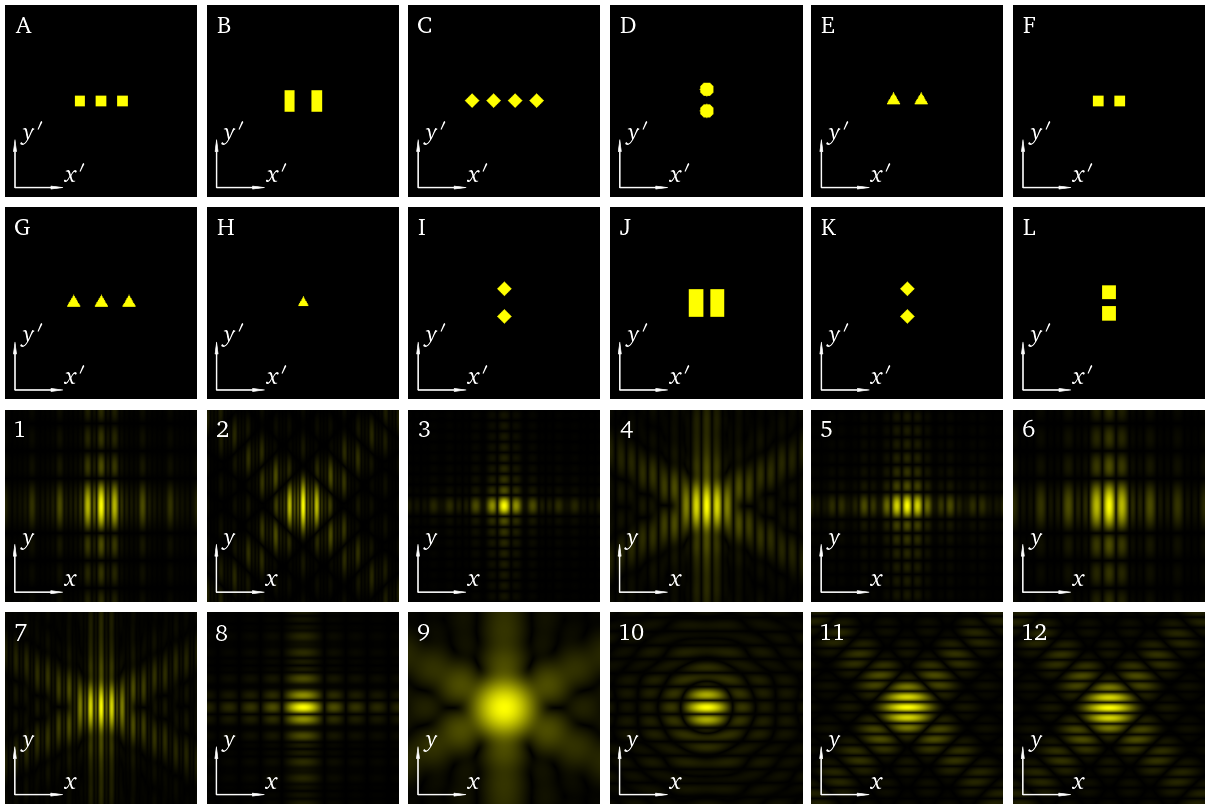

In [8]:
cols = 6
rows = 4
fig, axs = plt.subplots(rows,cols, figsize = (4*cols,4*rows),dpi=50)

for example in range(0,num):
    InputImage = Input_Image(selected_shape[example],selected_Nx[example],selected_Ny[example],selected_a[example],selected_d[example])
    ImageData = RGB_zoom_data(InputImage,[1.0,1.0,1.0],4.0)
    ax1_ref = int(fig_num[example]/6)
    ax2_ref = fig_num[example] - int(fig_num[example]/6) *6
    axs[ax1_ref,ax2_ref].imshow(ImageData)
    zoom_x_pts, zoom_y_pts, channels  = np.shape(ImageData)
    plotting_function(ax1_ref,ax2_ref,titles[example],"$x'$","$y'$")

    FImage = Fourier_Image(InputImage)
    zoom_x_pts, zoom_y_pts, channels  = np.shape(FImage)
    ax1_ref = int(selected_fig_order[example]/6)
    ax2_ref = selected_fig_order[example] - int(selected_fig_order[example]/6) *6
    axs[2+ax1_ref,ax2_ref].imshow(FImage)    
    plotting_function(2+ax1_ref,ax2_ref,ftitles[ax1_ref*cols+ax2_ref],"$x$","$y$")   
#    plotting_function(2+ax1_ref,ax2_ref,ftitles[example],"$x$","$y$") # SOLUTION LABELS 

plt.subplots_adjust(left=0.0,bottom=0.0,right=1.0,top=1.0,wspace=0.05,hspace=0.05)


In [9]:
fig.savefig('RandomArrays12_1.png',bbox_inches='tight')

If you want the save the solution it is printed out in this cell but remember if you run the random.choice cell again it will create a new
arrangent.

In [10]:
#Solution
for example in range(0,num):
    print (titles[example],selected_fig_order[example]+1)

A 1
B 5
C 2
D 10
E 4
F 6
G 7
H 9
I 12
J 3
K 11
L 8
